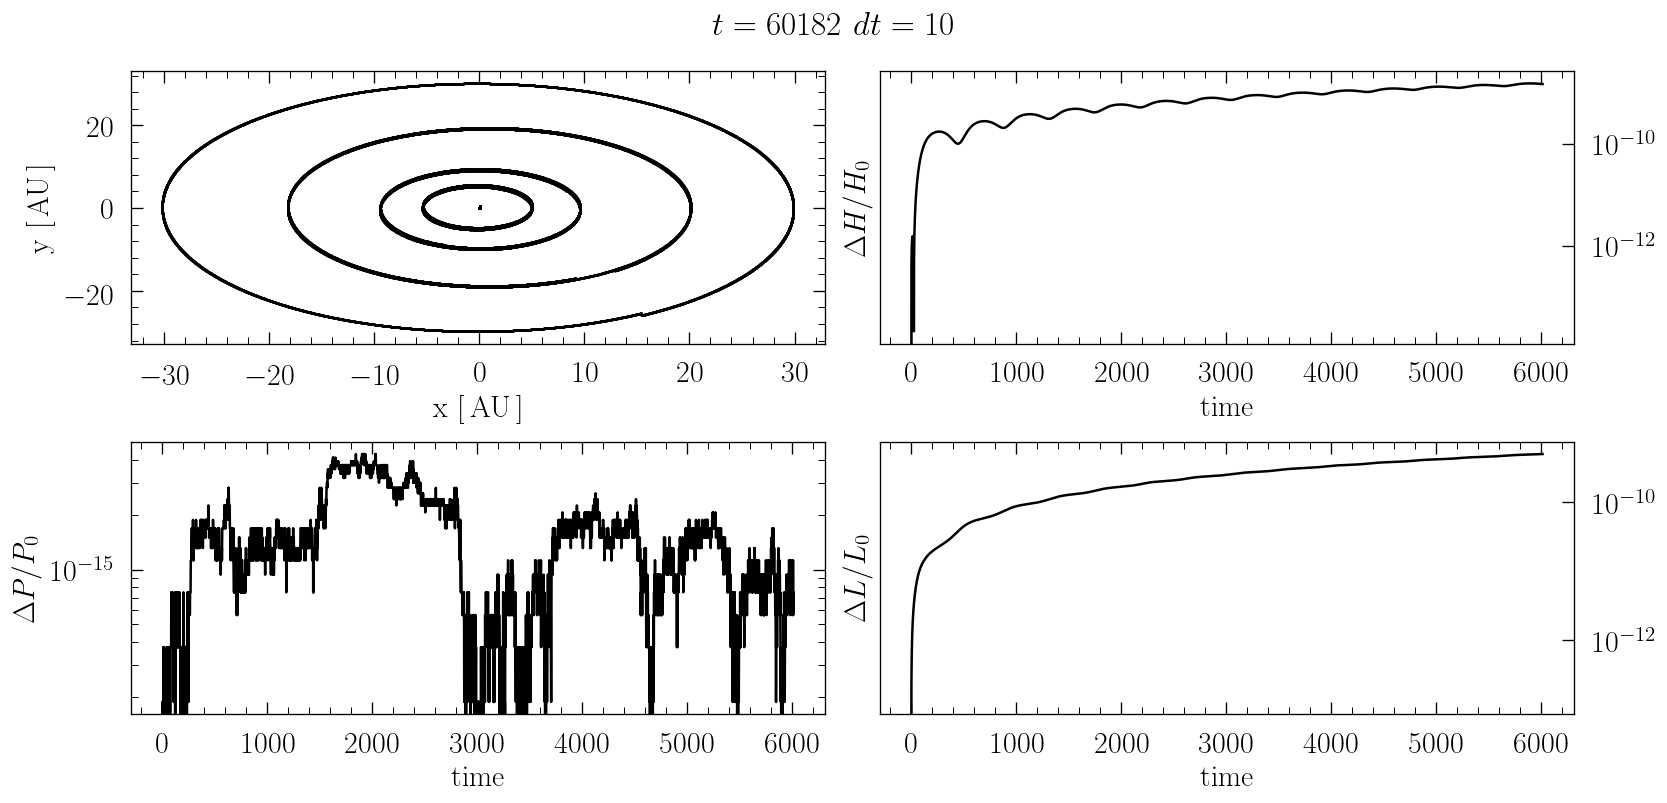

In [19]:
# =================================================================================
# --------------------------------------------------------------------- IMPORTS ---
# =================================================================================

import numpy as np
import pandas as pd
import numpy.linalg
import random
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib.ticker import AutoMinorLocator

# =================================================================================
# -------------------------------------------------------------------- FUNCTION ---
# =================================================================================

def integrator(method, system, h, maxTime): 

    """
    AVAILABLE METHODS: Euler, RK4, AB2, AB4, AB5, leapfrog
    AVAILABLE SYSTEMS: test, capture, random, solar system
    """
    
    # =============================================================================
    # ---------------------------------------------------------------- SETTINGS ---
    # =============================================================================
    
    plt.rcParams['text.usetex']        = True
    plt.rcParams['font.family']        = 'serif'
    plt.rcParams['font.serif']         = 'Computer Modern Roman'
    plt.rcParams['text.latex.preview'] = True
    plt.rcParams['axes.labelsize']     = 18.
    plt.rcParams['axes.titlesize']     = 18.
    plt.rcParams['xtick.labelsize']    = 18.
    plt.rcParams['ytick.labelsize']    = 18.
    plt.rcParams['xtick.top']          = False
    plt.rcParams['ytick.right']        = False
    plt.rcParams['xtick.direction']    = 'in'
    plt.rcParams['ytick.direction']    = 'in'
    plt.rcParams['xtick.major.size']   = 7.
    plt.rcParams['xtick.minor.size']   = 4.
    plt.rcParams['ytick.major.size']   = 7.
    plt.rcParams['ytick.minor.size']   = 4.
    plt.rcParams['legend.fontsize']    = 18.
    plt.rcParams['legend.frameon']     = True
    plt.rcParams['xtick.major.pad']    = 10
    plt.rcParams['ytick.major.pad']    = 10
    plt.rcParams['axes.titlepad']      = 10
    plt.rcParams['figure.figsize']     = (14,7)
    plt.rcParams['figure.titlesize']   = 24
    plt.rcParams['figure.dpi']         = 120
    plt.rcParams['axes.prop_cycle']    = cycler(color='bgrcmyk')
    
    # =============================================================================
    # ----------------------------------------------------------------- SYSTEMS ---
    # =============================================================================
    
    if system == 'test':
        
        G    = 1
        pos0 = np.array([[1.0,  0.0, 0.0], [-1.0,  0.0, 0.0]])
        vel0 = np.array([[0.0, 0.05, 0.0],  [0.0, -0.5, 0.0]])
        mass = np.array([[10], [1]])
        
        sys_xlabel = r'$\mathrm{x}$'
        sys_ylabel = r'$\mathrm{y}$'
        
    # -------------------------
    
    elif system == 'random':
        
        G    = 1
        N    = int(input('Enter the number of bodies: '))
        pos0 = np.random.random((N,3))*10
        vel0 = np.random.random((N,3))
        mass = np.random.random((N,1))*20
        
        sys_xlabel = r'$\mathrm{x}$'
        sys_ylabel = r'$\mathrm{y}$'
        
    # -------------------------    

    elif system == 'capture':
        
        G    = 1
        pos0 = np.array([[0.0, 0.0, 0.0], [20.0, 0.0, 0.0], [21.0, 0.0, 0.0]])
        vel0 = np.array([[0.0, 0.0, 0.0],  [0.0, 5.0, 0.0], [ 0.0, 1.0, 0.0]])
        mass = np.array([         [1000],             [25],              [1]])
        
        sys_xlabel = r'$\mathrm{x}$'
        sys_ylabel = r'$\mathrm{y}$'
        
    # -------------------------

    elif system == 'solar system':
        
        # NOTE: includes the sun and four gas giants
        # UNITS: mass in [M_odot], pos in [AU], vel in [AU/day]
        
        G = 2.959122082855911e-4
        
        pos0 = np.array([[0.,0.,0.],
                [4.84143144246472090E+00, -1.16032004402742839E+00, -1.03622044471123109E-01],
                [8.34336671824457987E+00,  4.12479856412430479E+00, -4.03523417114321381E-01],
                [1.28943695621391310E+01, -1.51111514016986312E+01, -2.23307578892655734E-01],
                [1.53796971148509165E+01, -2.59193146099879641E+01,  1.79258772950371181E-01]])
        vel0 = np.array([[0.,0.,0.],
                [1.66007664274403694E-03,  7.69901118419740425E-03, -6.90460016972063023E-05],
                [-2.7674251072686241E-03,  4.99852801234917238E-03,  2.30417297573763929E-05],
                [2.96460137564761618E-03,  2.37847173959480950E-03, -2.96589568540237556E-05],
                [2.68067772490389322E-03,  1.62824170038242295E-03, -9.51592254519715870E-05]])
        mass = np.array([1.00,
                9.54791938424326609E-04,
                2.85885980666130812E-04,
                4.36624404335156298E-05,
                5.15138902046611451E-05]).T
        
        sys_xlabel = r'$\mathrm{x}\,\,[\,\mathrm{AU}\,]$'
        sys_ylabel = r'$\mathrm{y}\,\,[\,\mathrm{AU}\,]$'
    
    # -------------------------
    
    elif system == 'solar system 2': # not working at the moment; trying to add the
                                     # inner planets and most notable satellites
        G = 2.959122082855911e-4
        table = pd.read_csv('Jul_19_2020.csv', sep=',', header=0)
        
        pos0 = np.transpose([table['X'], table['Y'], table['Z']])
        vel0 = np.transpose([table['VX'], table['VY'], table['VZ']])
        mass = table.Mass.tolist()
        
        pos0 = np.array([pos0])
        vel0 = np.array([vel0])
        mass = np.array([mass]).T
        
        sys_xlabel = r'$\mathrm{x}\,\,[\,\mathrm{AU}\,]$'
        sys_ylabel = r'$\mathrm{y}\,\,[\,\mathrm{AU}\,]$'
        
    # -------------------------
    
    else:
        
        print('Oops! That\'s not a valid system.')
    
    # =============================================================================
    # ----------------------------------------------------------------- PHYSICS ---
    # =============================================================================
    
    # Invariant regardless of method.

    def fx_fv(pos, vel, mass):

        fx = []
        fv = []

        for pos1, vel1, mass1 in zip(pos, vel, mass):

            accelArray = []

            fx += [vel1]

            for pos2, vel2, mass2  in zip(pos, vel, mass):

                if np.array_equal(pos1,pos2) == False:

                    r = pos2 - pos1
                    normr = np.linalg.norm(r)
                    accel = G * mass2 * r / normr**3
                    accelArray.append(accel)

                else:
                    continue

            accelArray = np.array(accelArray)
            acceleration = accelArray.sum(axis=0)

            fv += [acceleration]

        return np.array(fx), np.array(fv)
    
    # -------------------------

    def energy(pos, vel, mass):

        Karray = []
        Uarray = []

        for pos1, vel1, mass1, i in zip(pos, vel, mass, range(len(mass))):
            
            kineticEnergy = 0.5 * mass1 * np.linalg.norm(vel1)**2
            Karray.append(kineticEnergy)

            for pos2, vel2, mass2, j in zip(pos, vel, mass, range(len(mass))):

                if j > i:
                    r = pos2 - pos1
                    potentialEnergy = - G * mass1 * mass2 / np.linalg.norm(r)
                    Uarray.append(potentialEnergy)

                else:
                    continue

        Htot = np.sum(Karray) + np.sum(Uarray)

        return Htot
    
    # -------------------------

    def momentum(pos, vel, mass):

        momentumArray = []

        for pos1, vel1, mass1 in zip(pos, vel, mass):
            momentum = mass1 * vel1
            momentumArray.append(momentum)

        momentumArray = np.array(momentumArray)
        momentum = momentumArray.sum(axis=0)
        momentum = np.linalg.norm(momentum)

        return momentum
    
    # -------------------------

    def angularMomentum(pos, vel, mass):

        Larray = []

        for pos1, vel1, mass1 in zip(pos, vel, mass):
            angularmomentum = mass1 * np.cross(pos1,vel1)
            Larray.append(angularmomentum)

        Larray = np.array(Larray)
        angularmomentum = Larray.sum(axis=0)
        angularmomentum = np.linalg.norm(angularmomentum)

        return angularmomentum
    
    # =============================================================================
    # ----------------------------------------------------- INTEGRATION METHODS ---
    # =============================================================================
    
    x = []
    y = []
    m = []
    H = []
    P = []
    L = []
    
    t_range = int(maxTime/h)
    
    if method == "Euler":
        
        pos = pos0
        vel = vel0
        
        for t in range(0, t_range+1):

            k1pos, k1vel = fx_fv(pos, vel, mass)

            pos = pos + k1pos * h
            vel = vel + k1vel * h

            x += [pos[:,0]]
            y += [pos[:,1]]
            m += [np.ravel(mass)]

            H.append(energy(pos, vel, mass))
            P.append(momentum(pos, vel, mass))
            L.append(angularMomentum(pos, vel, mass))

    # -------------------------

    elif method == "RK4":
        
        pos = pos0
        vel = vel0
        
        for t in range(0, t_range+1):

            k1pos, k1vel = fx_fv(pos, vel, mass)
            k2pos, k2vel = fx_fv(pos+k1pos*h/2, vel+k1vel*h/2, mass)
            k3pos, k3vel = fx_fv(pos+k2pos*h/2, vel+k2vel*h/2, mass)
            k4pos, k4vel = fx_fv(pos+k3pos*h, vel+k3vel*h, mass)

            pos = pos + h / 6 * (k1pos + 2*k2pos + 2*k3pos + k4pos)
            vel = vel + h / 6 * (k1vel + 2*k2vel + 2*k3vel + k4vel)
            
            x += [pos[:,0]]
            y += [pos[:,1]]
            m += [np.ravel(mass)]
            
            H.append(energy(pos, vel, mass))
            P.append(momentum(pos, vel, mass))
            L.append(angularMomentum(pos, vel, mass))
            
    # -------------------------

    elif method == "AB2":

        k1pos, k1vel = fx_fv(pos0, vel0, mass)
        pos1 = pos0 + k1pos*h
        vel1 = vel0 + k1vel*h

        for t in range(0, t_range+1):

            pos2 = pos1 + 1.5*h*fx_fv(pos1,vel1,mass)[0] - 0.5*h*fx_fv(pos0,vel0,mass)[0]
            vel2 = vel1 + 1.5*h*fx_fv(pos1,vel1,mass)[1] - 0.5*h*fx_fv(pos0,vel0,mass)[1]

            x += [pos2[:,0]]
            y += [pos2[:,1]]
            m += [np.ravel(mass)]

            H.append(energy(pos2, vel2, mass))
            P.append(momentum(pos2, vel2, mass))
            L.append(angularMomentum(pos2, vel2, mass))

            pos0 = pos1 
            vel0 = vel1
            pos1 = pos2
            vel1 = vel2

    # -------------------------
            
    elif method == "AB4":

        k1pos, k1vel = fx_fv(pos0, vel0, mass)
        pos1 = pos0 + k1pos*h
        vel1 = vel0 + k1vel*h
        
        k2pos, k2vel = fx_fv(pos1, vel1, mass)
        pos2 = pos1 + k2pos*h
        vel2 = vel1 + k2vel*h
        
        k3pos, k3vel = fx_fv(pos2, vel2, mass)
        pos3 = pos2 + k3pos*h
        vel3 = vel2 + k3vel*h

        for t in range(0, t_range+1):

            pos4 = (pos3 + (55/24)*h*fx_fv(pos3,vel3,mass)[0] - 
                           (59/24)*h*fx_fv(pos2,vel2,mass)[0] + 
                           (37/24)*h*fx_fv(pos1,vel1,mass)[0] - 
                            (9/24)*h*fx_fv(pos0,vel0,mass)[0])
            vel4 = (vel3 + (55/24)*h*fx_fv(pos3,vel3,mass)[1] - 
                           (59/24)*h*fx_fv(pos2,vel2,mass)[1] + 
                           (37/24)*h*fx_fv(pos1,vel1,mass)[1] - 
                            (9/24)*h*fx_fv(pos0,vel0,mass)[1])
            
            x += [pos4[:,0]]
            y += [pos4[:,1]]
            m += [np.ravel(mass)]

            H.append(energy(pos4, vel4, mass))
            P.append(momentum(pos4, vel4, mass))
            L.append(angularMomentum(pos4, vel4, mass))

            pos0 = pos1 
            vel0 = vel1
            pos1 = pos2
            vel1 = vel2
            pos2 = pos3 
            vel2 = vel3
            pos3 = pos4
            vel3 = vel4

    # -------------------------
    
    elif method == "AB5":

        k1pos, k1vel = fx_fv(pos0, vel0, mass)
        pos1 = pos0 + k1pos*h
        vel1 = vel0 + k1vel*h
        
        k2pos, k2vel = fx_fv(pos1, vel1, mass)
        pos2 = pos1 + k2pos*h
        vel2 = vel1 + k2vel*h
        
        k3pos, k3vel = fx_fv(pos2, vel2, mass)
        pos3 = pos2 + k3pos*h
        vel3 = vel2 + k3vel*h
        
        k4pos, k4vel = fx_fv(pos3, vel3, mass)
        pos4 = pos3 + k4pos*h
        vel4 = vel3 + k4vel*h

        for t in range(0, t_range+1):

            pos5 = (pos4 + (1901/720)*h*fx_fv(pos4,vel4,mass)[0] -
                           (2774/720)*h*fx_fv(pos3,vel3,mass)[0] +
                           (2616/720)*h*fx_fv(pos2,vel2,mass)[0] -
                           (1274/720)*h*fx_fv(pos1,vel1,mass)[0] +
                            (251/720)*h*fx_fv(pos0,vel0,mass)[0])
            vel5 = (vel4 + (1901/720)*h*fx_fv(pos4,vel4,mass)[1] -
                           (2774/720)*h*fx_fv(pos3,vel3,mass)[1] +
                           (2616/720)*h*fx_fv(pos2,vel2,mass)[1] -
                           (1274/720)*h*fx_fv(pos1,vel1,mass)[1] +
                            (251/720)*h*fx_fv(pos0,vel0,mass)[1])

            x += [pos5[:,0]]
            y += [pos5[:,1]]
            m += [np.ravel(mass)]

            H.append(energy(pos5, vel5, mass))
            P.append(momentum(pos5, vel5, mass))
            L.append(angularMomentum(pos5, vel5, mass))

            pos0 = pos1 
            vel0 = vel1
            pos1 = pos2
            vel1 = vel2
            pos2 = pos3 
            vel2 = vel3
            pos3 = pos4
            vel3 = vel4
            pos4 = pos5
            vel4 = vel5
            
    # -------------------------

    elif method == "leapfrog":

        for t in range(0, t_range+1):

            k1pos, k1vel = fx_fv(posInit, velInit, mass)

            velHalf = vel0 + k1vel * h * 0.5
            posFull = pos0 + velHalf * h

            velFull = velHalf + fx_fv(posFull, velHalf, mass)[1] * h * 0.5

            x += [posFull[:,0]]
            y += [posFull[:,1]]
            m += [np.ravel(mass)]

            H.append(energy(posFull, velFull, mass))
            P.append(momentum(posFull, velFull, mass))
            L.append(angularMomentum(posFull, velFull, mass))


            posInit = posFull
            velInit = velFull
            
    # -------------------------
    
    else:
        print("Oops! That\'s not a valid method.")
        
    # -------------------------
        
    H = np.array(H)
    L = np.array(L)
    P = np.array(P)
        
    # =============================================================================
    # ---------------------------------------------------------------- PLOTTING ---
    # =============================================================================

    fig, axes = plt.subplots(nrows=2, ncols=2)
    
    fig.suptitle(f'$t={maxTime}\,\,dt={h}$\n', fontsize=20)
    
    # ------- plot to each subplot
    axes[0,0].plot(np.array(x), np.array(y), lw=0, marker='o', markersize=0.5, c='k')
    axes[0,1].plot(abs((H-H[0])/H[0]), c='k')
    axes[1,0].plot(abs((P-P[0])/P[0]), c='k')
    axes[1,1].plot(abs((L-L[0])/L[0]), c='k')
    
    axes[0,1].set_yscale('log')
    axes[1,0].set_yscale('log')
    axes[1,1].set_yscale('log')
    
    axes[0,1].yaxis.tick_right()
    axes[1,1].yaxis.tick_right()
    axes[0,0].yaxis.set_minor_locator(AutoMinorLocator(5))
    
    xlabels = [ sys_xlabel,            'time',            'time',            'time']
    ylabels = [ sys_ylabel, r'$\Delta H/H_0$', r'$\Delta P/P_0$', r'$\Delta L/L_0$']
    
    for ax, xlabel, ylabel in zip(axes.flatten(), xlabels, ylabels):
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        #ax.yaxis.set_label_position("left")
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.tick_params(right='true', top='true', which='both')
        
    fig.tight_layout(rect=[0, 0.03, 1, 0.93])

# =================================================================================
# -------------------------------------------------------- CALLING THE FUNCTION ---
# =================================================================================

"""
SOLAR SYSTEM: h = 10; maxTime = 60182 (1 Neptunian year ~ 60,182 Earth days)
RANDOM, TEST: h = 0.001; maxTime = 1000
"""

integrator(method='RK4', system='solar system', h=10, maxTime=60182)